In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 12})

In [35]:
def foo_alpha(r):
    if abs(r) >= 0.0000001:
        a = 1 - np.e**(-r)
        return (1-a/r)/a
    else:
        return 0.5

In [10]:
def foo_k_r(T):
    return k_r0 * np.e**(-E_a/(R_u*T))

In [19]:
def foo_k(T, gas_name):
    if gas_name == 'H2':
        vector_a = np.array([0.3975, 0.4814e-4, -1.073e-7, 4.6863e-11, -8.5361e-15, 5.6934e-19])
    elif gas_name == 'O2':
        vector_a = np.array([0.4697, -2.9819e-4, 2.0320e-7, -7.1938e-11, 12.311e-15, -8.0736e-19])
    elif gas_name == 'H2O':
        vector_a = np.array([0.3834, -1.8579e-4, 0.6266e-7, -1.0528e-11, 0.93554e-15, -0.38512e-19])
    else:
        print('Houston we have a problem')
    return 1 + sum(vector_a * np.array([1, T, T**2, T**3, T**4, T*5]))

In [11]:
p_0 = 34.5e6 # начальное давление
T_0 = 300 # начальная температура
R_u = 8.31446262 # универсальная газовая постоянная
hi_O2_and_H2_0 = 1/8 # начальное соотношение мольных долей
W_0 = 0.005 # объем каморы

mu_H2 = 2*10**(-3) # молярная масса водорода
mu_O2 = 32*10**(-3) # молярная масса кислорода
mu_H2O = 18*10**(-3) # молярная масса воды

In [24]:
E_a = 60e3 # энергия активации
k_r0 = 9.87e8 # предэскп. множитель 
Q_t = 13.4e6 # энергия образования 1 кг продуктов реакций 

In [25]:
def C_initial(p_0, W_0, T_0, hi_second_to_first):
    n_smesi = p_0 * W_0/(R_u * T_0)
    n_first_0 = n_smesi/(hi_second_to_first+1)
    n_second_0 =  n_first_0 * hi_second_to_first  
    n_result_0 = 0
    return np.array([n_first_0/W_0,
                    n_second_0/W_0,
                    n_result_0])

In [26]:
def k_smesi(T, n_H2, n_O2, n_H2O):
    help_value = (n_H2/(foo_k(T,'H2')-1) + n_O2/(foo_k(T,'O2')-1) + n_H2O/(foo_k(T,'H2O')-1))**(-1)
    return 1 + n_H2*help_value + n_O2*help_value + n_H2O*help_value

In [ ]:
def alha_QSS(C_n, T, dt, W_n, W_n_1):
        P_n = np.array([0, 
                        0, 
                        foo_k_r(T)*C_n[0]*C_n[1]**(1/2)])

        D_n = np.array([foo_k_r(T)*C_n[1]**(1/2), 
                        1/2*foo_k_r(T)*C_n[0]*C_n[1]**(-1/2),
                        0])
        
        foo_alpha_res = np.array([0,0,0])
        for i in range(len(D_n)):
            foo_alpha_res[i] = foo_alpha(D_n[i]*dt)

        C_n_kr = W_n/W_n_1 * (C_n + (dt *(P_n-C_n*D_n))/(1+foo_alpha_res*D_n*dt))

        if C_n_kr[1] >= 0 and C_n_kr[1] >= 0:
            D_n_kr = (np.array([foo_k_r(T)*C_n_kr[1]**(1/2), 
                                1/2*foo_k_r(T)*C_n_kr[0]*C_n_kr[1]**(-1/2),
                                0]) + D_n)/2
        else:
            D_n_kr = np.array([0,0,0])

        foo_alpha_res = np.array([0,0,0])
        for i in range(len(D_n_kr)):
            foo_alpha_res[i] = foo_alpha(D_n_kr[i]*dt)


        if C_n_kr[0] >= 0 and C_n_kr[1] >= 0:
            P_n_kr = foo_alpha_res*np.array([0, 
                                             0, 
                                             foo_k_r(T)*C_n_kr[0]*C_n_kr[1]**(1/2)]) + (1-foo_alpha_res)*P_n   
        else:
            P_n_kr = np.array([0,0,0])

        return W_n/W_n_1 * (C_n + (dt *(P_n_kr-C_n*D_n_kr))/(1+foo_alpha_res*D_n_kr*dt))

In [55]:
def termodynamic_system(p_0, W_0, T_0, hi_second_to_first):
    tau = 0   
    
    C_n_1 = C_initial(p_0, W_0, T_0, hi_second_to_first)
    
    k_smesi_T_0 = k_smesi(T_0, 
                          C_n_1[0] * W_0, 
                          C_n_1[1] * W_0, 
                          C_n_1[2] * W_0)
    W_n_1 = W_0
    W_n = W_0
    T = T_0 
    p_m = p_0 

    tau_arr = np.array([])
    p_m_arr = np.array([])
    T_arr = np.array([])
    C_H2_arr = np.array([])
    C_O2_arr = np.array([])
    C_H2O_arr = np.array([])
    
    dt = 1e-9
    flag_dt = 0
    schetchik = 0

    while (C_n_1[0] >= 1e-3) and (C_n_1[1] >= 1e-3):
        
        schetchik+=1
        
        tau += dt
        if tau<=300_000*dt and flag_dt == 0:
            dt = 1e-9
        elif ((p_m_arr[-1] - p_m_arr[-2])/p_m_arr[-2] * 100) >= 2 and flag_dt == 0:
            dt = 1e-10
            flag_dt = 1
        elif ((p_m_arr[-1] - p_m_arr[-2])/p_m_arr[-2] * 100) >= 6 and flag_dt == 1:
            dt = 1e-12
            flag_dt = 2
        elif ((p_m_arr[-1] - p_m_arr[-2])/p_m_arr[-2] * 100) >= 10 and flag_dt == 2:
            dt = 1e-14
            flag_dt = 3
        elif ((p_m_arr[-1] - p_m_arr[-2])/p_m_arr[-2] * 100) <= 0 and flag_dt == 3:
            dt = 1e-9
            flag_dt = 4
        elif flag_dt == 4:
            dt = 5e-9

        C_n = C_n_1

        M_p = mu_H2O * C_n[2] * W_n
        
        n = C_n * W_n
        
        m = [n[0]*mu_H2,
             n[1]*mu_O2,
             n[2]*mu_H2O]
        
        n_smesi = n[0] +  n[1] +  n[2]
        
        p_m = (k_smesi(T, n[0], n[1], n[2])-1)/W_n * ((p_0*W_0)/(k_smesi_T_0-1) + Q_t*M_p)
        
        T = p_m*W_n/(R_u*n_smesi)

        C_n_1 = alha_QSS(C_n, T, dt, W_n, W_n_1)

        if schetchik % 10_000 == 0:
            tau_arr = np.append(tau_arr, tau)
            C_H2_arr = np.append(C_H2_arr, C_n_1[0])
            C_O2_arr = np.append(C_O2_arr, C_n_1[1])
            C_H2O_arr = np.append(C_H2O_arr, C_n_1[2])
            T_arr = np.append(T_arr, T)
            p_m_arr = np.append(p_m_arr, p_m)
            print(tau, C_n_1, p_m/10**6, dt)
    
    return {'tau':tau_arr, 'C_H2_arr':C_H2_arr, 'C_O2_arr':C_O2_arr, 'C_H2O_arr':C_H2O_arr,
           'T':T_arr, 'p_m':p_m_arr}

In [56]:
res = termodynamic_system(p_0, W_0, T_0, hi_O2_and_H2_0)

1.0000000000000058e-05 [1.22943364e+04 1.53672791e+03 1.71036278e-01] 34.51620376630528 1e-09
1.9999999999997013e-05 [1.22941634e+04 1.53664140e+03 3.44043980e-01] 34.53259527877713 1e-09
2.999999999998506e-05 [1.22939883e+04 1.53655389e+03 5.19067060e-01] 34.54917710001063 1e-09
4.0000000000005235e-05 [1.22938113e+04 1.53646535e+03 6.96150936e-01] 34.565953510293866 1e-09
5.000000000002716e-05 [1.22936321e+04 1.53637575e+03 8.75342555e-01] 34.58292893367311 1e-09
6.000000000004909e-05 [1.22934507e+04 1.53628508e+03 1.05669046e+00] 34.600107944409885 1e-09
7.000000000007101e-05 [1.22932672e+04 1.53619330e+03 1.24024485e+00] 34.61749527380256 1e-09
8.000000000009294e-05 [1.22930813e+04 1.53610040e+03 1.42605770e+00] 34.63509581739793 1e-09
9.000000000011486e-05 [1.22928932e+04 1.53600633e+03 1.61418278e+00] 34.65291464261905 1e-09
0.00010000000000013679 [1.22927027e+04 1.53591109e+03 1.80467579e+00] 34.67095699683903 1e-09
0.00011000000000015872 [1.22925098e+04 1.53581463e+03 1.99759442

0.0008900000000089677 [12247.38570135  1513.25257478    47.12170066] 38.940796216143056 1e-09
0.0009000000000091252 [12244.46897068  1511.79420939    50.0384314 ] 39.214044647945315 1e-09
0.0009100000000092826 [12241.04200498  1510.08072647    53.4653972 ] 39.534843201311716 1e-09
0.0009200000000094401 [12236.9029284   1508.01118807    57.60447392] 39.92193981105924 1e-09
0.0009300000000095975 [12231.70470546  1505.41207643    62.80269708] 40.40752418490975 1e-09
0.000940000000009755 [12224.77497749  1501.94721214    69.73242546] 41.05386527939595 1e-09
0.0009500000000099124 [12214.53363175  1496.8265386     79.97377208] 42.00698804346113 1e-09
0.0009510009000102534 [12213.19547155  1496.15745849    81.31193231] 42.13145070123987 1e-10
0.0009520009000105944 [12211.77402747  1495.44673644    82.7333764 ] 42.263500466247564 1e-10
0.0009530009000109354 [12210.25890984  1494.68917761    84.24849405] 42.40419873329276 1e-10
0.0009540009000112764 [12208.63770468  1493.87857501    85.86969924

0.0009696409990138342 [12001.63657344  1390.37799589   292.87084821] 61.2112968881928 1e-12
0.0009696509990137943 [11994.58019301  1386.84980533   299.92722909] 61.82674023217365 1e-12
0.0009696609990137543 [11986.43475201  1382.77708437   308.07267069] 62.53542716372904 1e-12
0.0009696709990137144 [11976.84679113  1377.98310329   317.6606324 ] 63.36722167016024 1e-12
0.0009696809990136744 [11965.26800263  1372.1937081    329.23942213] 64.36826394168308 1e-12
0.0009696909990136345 [11950.78561117  1364.95251088   343.72181551] 65.61498688004623 1e-12
0.0009697009990135945 [11931.72288046  1355.42114293   362.78454959] 67.24691973702282 1e-12
0.0009697109990135545 [11904.50819569  1341.81379515   389.99924133] 69.55876967889833 1e-12
0.0009697209990135146 [11859.34518118  1319.23227254   435.16227562] 73.3485478247576 1e-12
0.0009697309990134746 [11748.40588091  1263.76251639   546.10171148] 82.4098964385569 1e-12
0.0009697311000037778 [11746.2548673   1262.68700955   548.25272513] 82.5

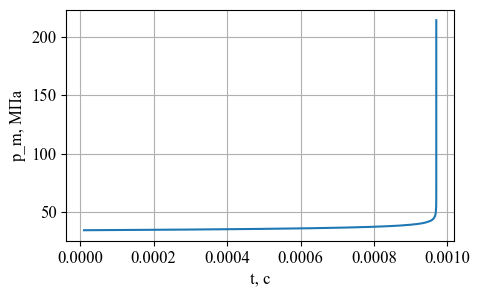

In [57]:
plt.figure(figsize=(5,3))
plt.plot(res['tau'],res['p_m']/10**6)
plt.xlabel('t, с')
plt.ylabel('p_m, МПа')
plt.grid()

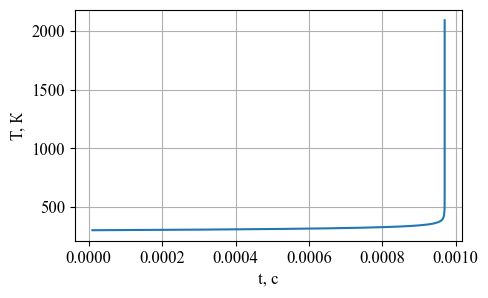

In [58]:
plt.figure(figsize=(5,3))
plt.plot(res['tau'],res['T'])
plt.xlabel('t, с')
plt.ylabel('T, К')
plt.grid()

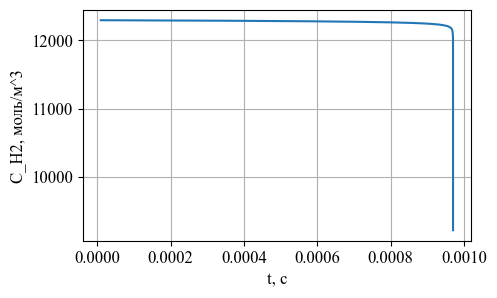

In [60]:
plt.figure(figsize=(5,3))
plt.plot(res['tau'],res['C_H2_arr'])
plt.xlabel('t, с')
plt.ylabel('C_H2, моль/м^3')
plt.grid()

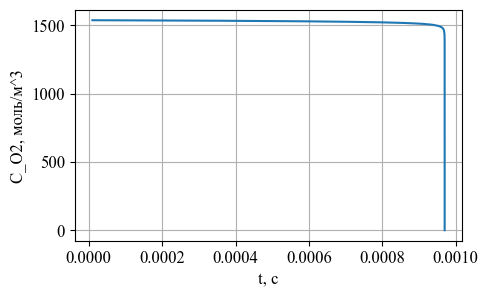

In [61]:
plt.figure(figsize=(5,3))
plt.plot(res['tau'],res['C_O2_arr'])
plt.xlabel('t, с')
plt.ylabel('C_O2, моль/м^3')
plt.grid()

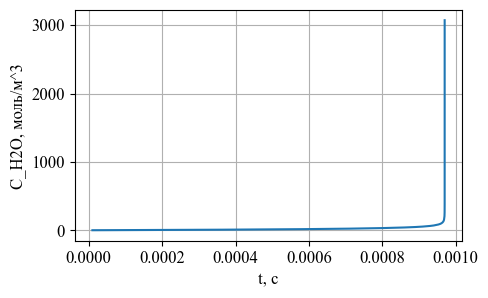

In [62]:
plt.figure(figsize=(5,3))
plt.plot(res['tau'],res['C_H2O_arr'])
plt.xlabel('t, с')
plt.ylabel('C_H2O, моль/м^3')
plt.grid()